In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import time
import numpy as np

In [2]:
print ("version:", torch.__version__)
print ("gpu device:", torch.cuda.device_count())

version: 0.3.1
gpu device: 1


In [3]:
batch_size = 64
epochs = 30
seed = 1
lr = 0.01
momentum = 0.5
log_interval = 10
PATH = "visualize_optimizarion_model" # model path
cuda = torch.cuda.is_available()

if cuda:
    torch.cuda.manual_seed(seed)
kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}

In [4]:
train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
                batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
                datasets.MNIST('../data', train=False,
                    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])),
                batch_size=batch_size, shuffle=True, **kwargs)

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # flatten
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x) # transform to logits

In [6]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__() #load super class for training data
        self.fc1 = nn.Linear(784, 50)
        self.fc2 = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, x): #feed forward
        layer1 = x.view(-1, 784) # flatten
        layer2 = self.relu(self.fc1(layer1))
        layer3 = self.relu(self.fc2(layer2))
        return F.log_softmax(layer3, dim=1)

In [7]:
loss_history = []
acc_history = []
weights_history = []

In [8]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        data, target = Variable(data), Variable(target)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        '''
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]), end='\r')
        '''

In [9]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        #pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, accuracy
    '''
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    '''

In [10]:
def get_model_weights():
    weights = np.array([])
    for p in model.parameters():
        weights = np.concatenate((weights, np.ndarray.flatten(p.cpu().data.numpy())))
    return weights

In [11]:
weight_num = 0
for i in range(8):
    model = DNN()
    if cuda:
        model.cuda()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    event_loss = []
    event_acc = []
    event_weights = []
    
    for epoch in range(epochs):
        print("Event %d, Epoch %d" % (i+1, epoch), end='\r')
        train(epoch)
        loss, acc = test(epoch)
        if epoch%3 == 0:
            event_loss.append(loss)
            event_acc.append(acc)
            weights = get_model_weights()
            event_weights.append(weights)
            
        
    #save_result(i)
    loss_history.append(event_loss)
    acc_history.append(event_acc)
    weights_history.append(event_weights)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

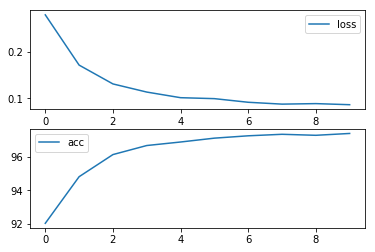

In [13]:
plt.clf()
plt.subplot(211)
e = list(range(len(loss_history[0])))
plt.plot(e, loss_history[0], label="loss")
plt.legend()
plt.subplot(212)
e = list(range(len(acc_history[0])))
plt.plot(e, acc_history[0], label="acc")
plt.legend()
plt.show()

The principal components (eigenvectors of the covariance matrix) correspond to the direction (in the original n-dimensional space) with the greatest variance

In [14]:
colormap = plt.cm.gist_ncar 
colors = [colormap(i) for i in np.linspace(0, 0.9, 8)]
print ("weight shape:", np.array(weights_history).shape)

weight shape: (8, 10, 39760)


In [15]:
from sklearn.decomposition import PCA

In [16]:
pca_weights = []
for i in range(8):
    pca = PCA(n_components=2)
    tmp = pca.fit_transform(weights_history[i])
    pca_weights.append(tmp)
print ("pca shape:", np.array(pca_weights).shape)

pca shape: (8, 10, 2)


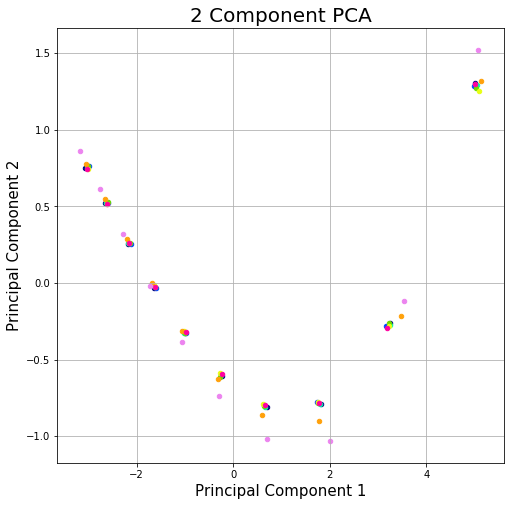

In [17]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

for target, color, label in zip(pca_weights, colors, acc_history):
    ax.scatter(target[:, 0], target[:, 1], c = color, s = 20)

ax.grid()
plt.savefig('pca.png')

In [18]:
from sklearn.manifold import TSNE

In [19]:
tsne_weights = []
for i in range(8):
    T = TSNE(n_components=2, perplexity=40)
    tmp = T.fit_transform(weights_history[i])
    tsne_weights.append(tmp)
print ("tsne weights shape:", np.array(tsne_weights).shape)

tsne weights shape: (8, 10, 2)


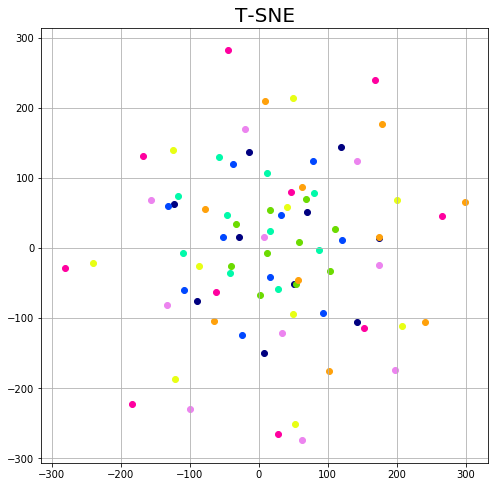

In [20]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.set_title('T-SNE', fontsize = 20)

for i in range(8):
    x = tsne_weights[i][:, 0]
    y = tsne_weights[i][:, 1]
    ax.scatter(x, y, c= colors[i])
    #for idx in range(len(x)):
    #    ax.annotate(str(acc_history[i][idx]), (x[idx], y[idx]))

ax.grid()
plt.savefig('tsne.png')

In [21]:
import pickle

with open('acc', 'wb') as f:
    pickle.dump(acc_history, f)
with open('loss', 'wb') as f:
    pickle.dump(loss_history, f)
with open('weights', 'wb') as f:
    pickle.dump(weights_history, f)
with open('pca_weights', 'wb') as f:
    pickle.dump(pca_weights, f)
with open('tsne_weights', 'wb') as f:
    pickle.dump(tsne_weights, f)
    
torch.save(model.state_dict(), PATH)

#model.load_state_dict(torch.load(PATH))
#with open ('outfile', 'rb') as fp:
#    itemlist = pickle.load(fp)